In [1]:
import numpy as np
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler, OneHotEncoder


def generate_data(n):
    '''
    产生数据
    '''
    np.random.seed(12046)
    blobs = make_blobs(n_samples=n, centers=[[-2, -2], [2, 2]])
    circles = make_circles(n_samples=n, factor=.4, noise=.05)
    moons = make_moons(n_samples=n, noise=.05)
    blocks = np.random.rand(n, 2) - 0.5
    y = (blocks[:, 0] * blocks[:, 1] < 0) + 0
    blocks = (blocks, y)
    # 由于神经网络对数据的线性变换不稳定，因此对数据做归一化处理
    scaler = StandardScaler()
    blobs = (scaler.fit_transform(blobs[0]), blobs[1])
    circles = (scaler.fit_transform(circles[0]), circles[1])
    moons = (scaler.fit_transform(moons[0]), moons[1])
    blocks = (scaler.fit_transform(blocks[0]), blocks[1])
    return blobs, circles, moons, blocks

def draw_data(ax, data):
    '''
    将数据可视化
    '''
    x, y = data
    label1 = x[y > 0]
    ax.scatter(label1[:, 0], label1[:, 1], marker='o')
    label0 = x[y == 0]
    ax.scatter(label0[:, 0], label0[:, 1], marker='^', color='k')
    return ax

def draw_model(ax, model):
    '''
    将模型的分离超平面可视化
    '''
    x1 = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    x2 = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100)
    x1, x2 = np.meshgrid(x1, x2)
    y = model.predict_proba(np.c_[x1.ravel(), x2.ravel()])[:, 1]
    y = y.reshape(x1.shape)
    ax.contourf(x1, x2, y, levels=[0, 0.5], colors=['gray'], alpha=0.4)
    return ax

def visualize(data):
    '''
    将结果可视化
    '''
    # 创建一个图形框
    fig = plt.figure(figsize=(10, 10), dpi=80)
    fig1 = plt.figure(figsize=(10, 10), dpi=80)
    # 在图形框里画四幅图
    for i in range(len(data)):
        ax = fig.add_subplot(2, 2, i+1)
        ax1 = fig1.add_subplot(2, 2, i+1)
        draw_data(ax, data[i])
        draw_data(ax1, data[i])
        draw_model(ax1, train_logit(data[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)
    plt.show()

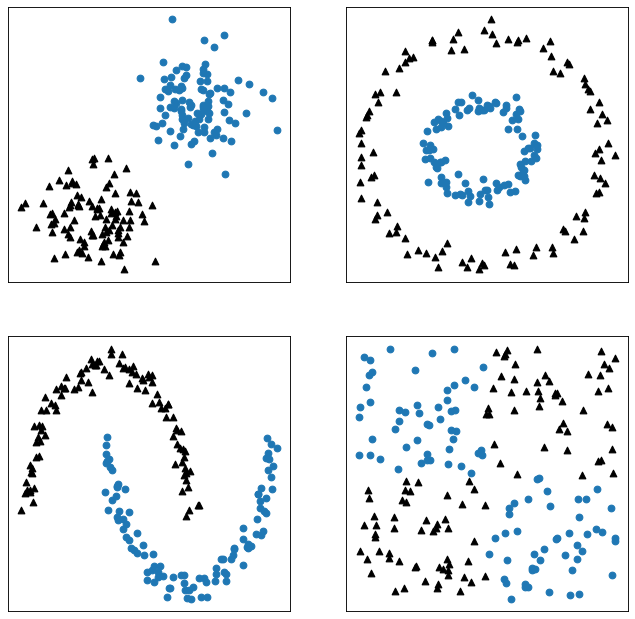

In [2]:
# 将数据可视化
import matplotlib.pyplot as plt
%matplotlib inline


data = generate_data(200)

fig = plt.figure(figsize=(10, 10), dpi=80)
for i in range(len(data)):
    ax = fig.add_subplot(2, 2, i+1)
    draw_data(ax, data[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [3]:
from sklearn.linear_model import LogisticRegression


def train_logit(data):
    '''
    训练逻辑回顾模型
    '''
    x, y = data
    model = LogisticRegression()
    model.fit(x, y)
    return model

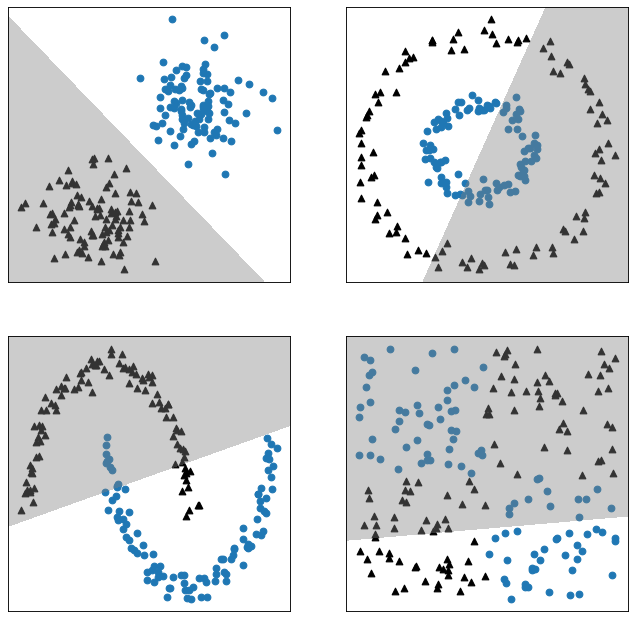

In [4]:
# 将逻辑回归的结果可视化
fig = plt.figure(figsize=(10, 10), dpi=80)
for i in range(len(data)):
    ax = fig.add_subplot(2, 2, i+1)
    draw_data(ax, data[i])
    draw_model(ax, train_logit(data[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
import torch
import torch.nn.functional as F
from utils import Linear, Sigmoid, Sequential


torch.manual_seed(12046)

def define_mlp():
    '''
    定义多层感知器模型
    '''
    model = Sequential([
        Linear(2, 4), Sigmoid(),
        Linear(4, 4), Sigmoid(),
        Linear(4, 2)
    ])
    # 对于模型参数，需要记录它们的梯度（为反向传播做准备）
    for p in model.parameters():
        p.requires_grad = True
    return model

In [6]:
def train_mlp(model, data):
    '''
    训练多层感知器模型
    '''
    # 标准随机梯度下降法的超参数
    max_steps = 40000
    batch_size = 20
    lossi = []
    x, y = torch.tensor(data[0]).float(), torch.tensor(data[1])
    _prob = torch.ones(x.shape[0]) / x.shape[0]

    for i in range(max_steps):
        # 构造批次训练数据
        ## 不放回的随机抽样
        ix = _prob.multinomial(batch_size)
        xb = x[ix]
        yb = y[ix]
        # 向前传播
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        # 反向传播
        loss.backward()
        # 更新模型参数
        ## 学习速率衰减
        learning_rate = 0.1 if i < 20000 else 0.01
        with torch.no_grad():
            for p in model.parameters():
                p -= learning_rate * p.grad
                p.grad = None
        lossi.append(loss.item())
    return lossi

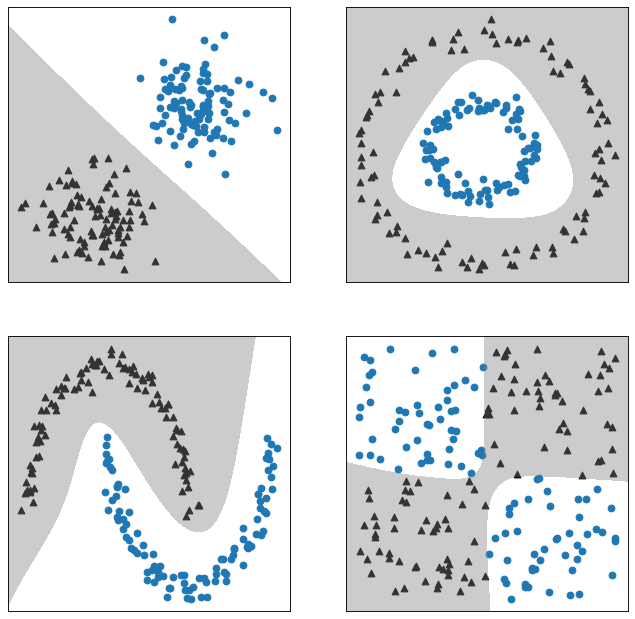

In [7]:
# 将多层感知器的结果可视化
loss = {}
fig = plt.figure(figsize=(10, 10), dpi=80)
for i in range(len(data)):
    ax = fig.add_subplot(2, 2, i+1)
    draw_data(ax, data[i])
    # 搭建多层感知器模型
    model = define_mlp()
    # 训练多层感知器模型
    loss[i] = train_mlp(model, data[i])
    draw_model(ax, model)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('mlp_result.png', dpi=200)
plt.show()

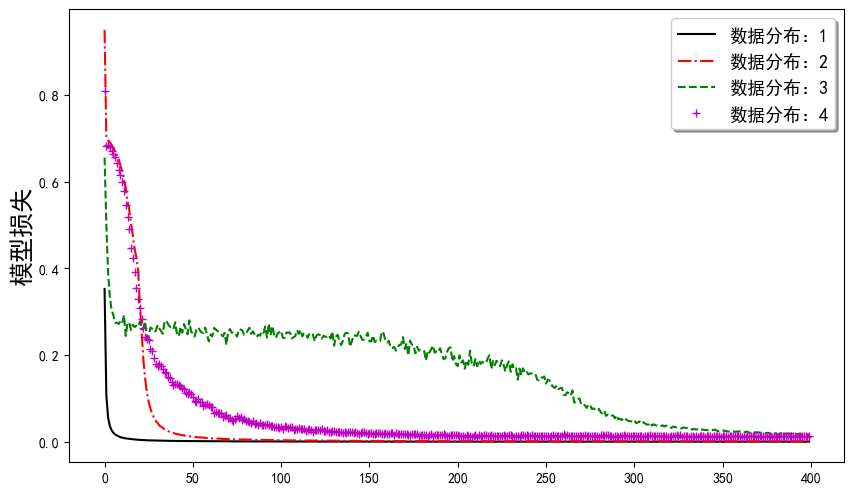

In [8]:
# 创建一个图形框
fig = plt.figure(figsize=(10, 6), dpi=100)
# 在图形框里只画一幅图
ax = fig.add_subplot(111)
# 解决中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 13})
ax.set_ylabel('模型损失', fontsize=18)
style = ['k', 'r-.', 'g--', 'm+']
for i in range(4):
    # 损失波动太大，按100次算一次平均值，然后作图
    _loss = torch.tensor(loss[i]).view(-1, 100).mean(1)
    ax.plot(_loss, style[i], label='数据分布：%s' % (i + 1))
legend = plt.legend(shadow=True)
plt.savefig('mlp_loss.png', dpi=200)
plt.show()